In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV


In [172]:
df = pd.read_csv('/kaggle/input/sas-viya-for-learners-challenge-2024-private/hmeq_train.csv')
df.head()

,id,default,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,16537,0,20900,58299.0,78684.00,DebtCon,NaN,3.0,0.0,0.0,98.662820,0.0,16.0,38.972004
1,14800,0,17400,56111.0,114521.00,HomeImp,Office,2.0,NaN,2.0,154.855524,1.0,24.0,38.695084
2,11317,0,8700,57254.0,86883.00,HomeImp,Other,16.0,0.0,0.0,172.166563,0.0,28.0,25.043437
3,13023,0,6000,69876.0,94394.07,HomeImp,Other,0.0,0.0,1.0,179.566667,0.0,32.0,NaN
4,11652,0,9700,75566.0,92066.00,DebtCon,Office,14.0,0.0,0.0,94.987922,0.0,8.0,25.161183


In [173]:
df['late_payments'].value_counts()


late_payments
0.0     3665
1.0      561
2.0      214
3.0      109
4.0       70
5.0       32
6.0       22
7.0       11
8.0        5
11.0       2
10.0       2
15.0       1
12.0       1
Name: count, dtype: int64

In [174]:
df['derogatory_reports'].value_counts()

derogatory_reports
0.0     3956
1.0      375
2.0      136
3.0       53
4.0       16
6.0       15
5.0       12
7.0        7
8.0        5
9.0        3
10.0       1
Name: count, dtype: int64

In [175]:
df.isnull().sum()

id                       0
default                  0
loan_amount              0
mortgage_amount        451
property_value          95
loan_reason            223
occupation             241
occupation_length      450
derogatory_reports     619
late_payments          503
oldest_credit_line     267
recent_credit          436
credit_number          196
ratio                 1113
dtype: int64

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5198 entries, 0 to 5197
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5198 non-null   int64  
 1   default             5198 non-null   int64  
 2   loan_amount         5198 non-null   int64  
 3   mortgage_amount     4747 non-null   float64
 4   property_value      5103 non-null   float64
 5   loan_reason         4975 non-null   object 
 6   occupation          4957 non-null   object 
 7   occupation_length   4748 non-null   float64
 8   derogatory_reports  4579 non-null   float64
 9   late_payments       4695 non-null   float64
 10  oldest_credit_line  4931 non-null   float64
 11  recent_credit       4762 non-null   float64
 12  credit_number       5002 non-null   float64
 13  ratio               4085 non-null   float64
dtypes: float64(9), int64(3), object(2)
memory usage: 568.7+ KB


In [177]:
def setOccupation(df):
  occupation = df[0]
  loan_reason = df[1]
  loan_amount = df[2]

  occupation_array = ['Office', 'Other', 'ProfExe','Mgr']

  if pd.isnull(occupation):
    if loan_reason == 'HomeImp':
      return 'Office'
    elif loan_amount > 25000:
      return 'Self'
    elif loan_amount < 15000 and loan_reason == 'DebtCon':
      return 'Sales'
    elif loan_amount < 7000 and loan_reason == 'IntImp':
      return 'Sales'
    else:
      return random.choice(occupation_array)
  else:
    return occupation


<Axes: xlabel='loan_reason', ylabel='loan_amount'>

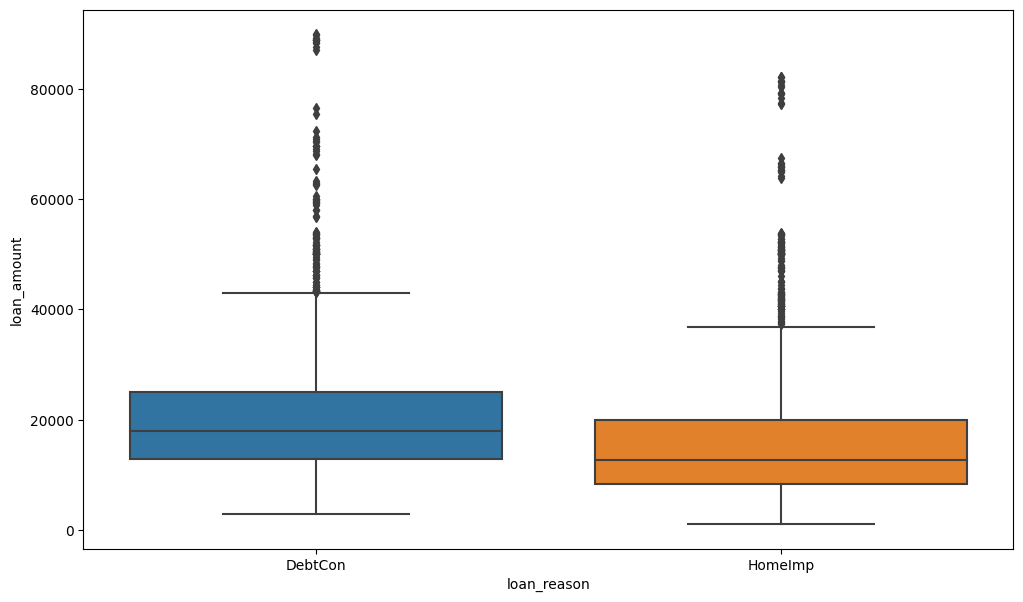

In [178]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='loan_reason',y='loan_amount',data=df)

In [179]:
def setLoanReason(df):
    occupation = df[0]
    loan_reason = df[1]
    loan_amount = df[2]

    if pd.isnull(loan_reason):
        if occupation == 'Sales':
            return 'DebtCon'
        elif loan_amount > 20000:
            return 'DebtCon'
        else:
            return 'HomeImp'
    else:
        return loan_reason


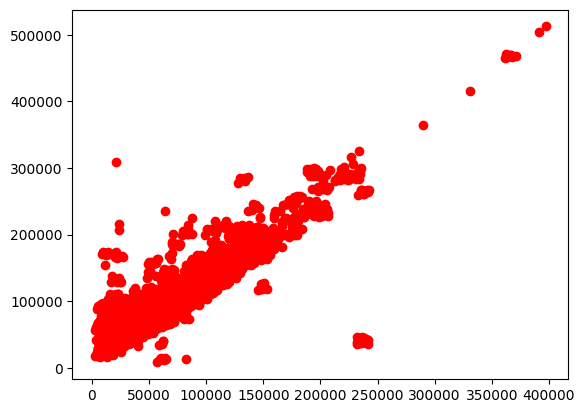

In [180]:
mortgage = df.iloc[:, 3].values.reshape(-1,1)
property_train = df.iloc[:,4].values.reshape(-1,1)
plt.scatter(mortgage, property_train, color = 'red')
plt.show()

In [181]:
#mortgage = 0.7*property

def setMortgage(df):
  mortgage = df[0]
  property = df[1]
  if pd.isnull(mortgage):
    return 0.7*property
  else:
    return np.mean(mortgage)

In [182]:
def setProperty(df):
  mortgage = df[0]
  property = df[1]
  if pd.isnull(property):
    return (10/7)*mortgage
  else:
    return np.mean(property)



<Axes: xlabel='occupation', ylabel='occupation_length'>

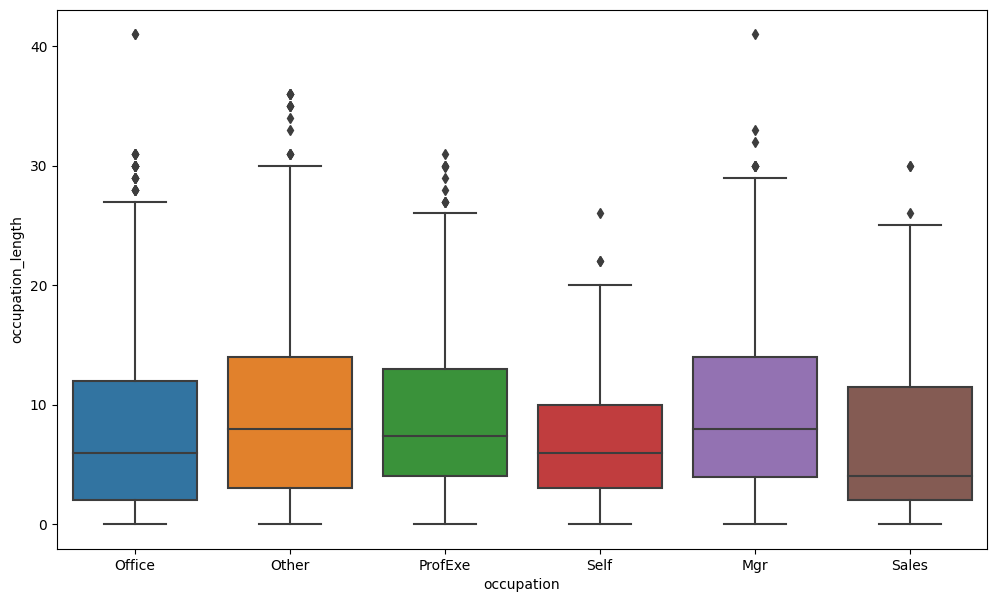

In [183]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='occupation',y='occupation_length',data=df)

In [184]:
def setOccupationLength(df):
  occupation = df[0]
  occupation_length = df[1]
  if pd.isnull(occupation_length):
    if occupation == 'Sales':
      return 5
    elif occupation == 'Office' or occupation == 'Self':
      return 6
    elif occupation == 'ProfExe'or occupation == 'Mgr':
      return 7
    else:
      return 8
  else:
    return occupation_length

<Axes: xlabel='derogatory_reports', ylabel='late_payments'>

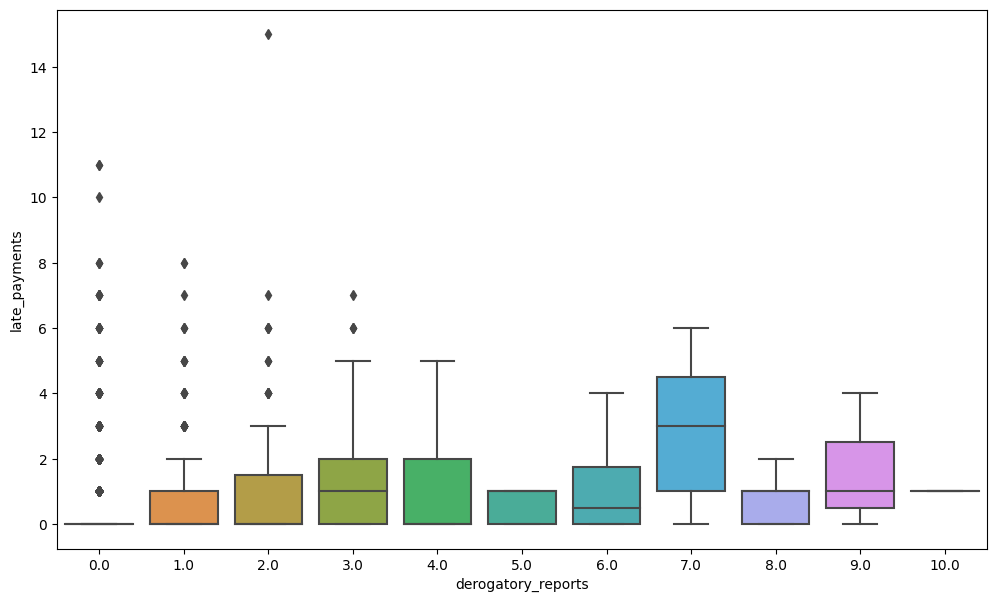

In [185]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='derogatory_reports',y='late_payments',data=df)

In [186]:
def setPayments(df):
    derogatory_reports = df[0]
    late_payments = df[1]
    if pd.isnull(late_payments):
        if derogatory_reports == 0 or derogatory_reports == 5:
          return 0
        elif derogatory_reports in {9,10}:
          return 1
        elif derogatory_reports in {1, 2, 4, 6, 8}:
          return 2
        elif derogatory_reports == 3:
          return 5
        else:
          return 6
    else:
        return late_payments


In [187]:
def derogatoryReports(df):
    derogatory_reports = df[0]
    late_payments = df[1]
    if pd.isnull(derogatory_reports):
        if late_payments == 0:
            return np.random.choice([0,5])
        if late_payments == 1:
            return np.random.choice([9,10])
        if late_payments == 2:
            return np.random.choice([1,2,4,6,8])
        if late_payments == 5:
            return 3
        if late_payments == 6:
            return 7
    else:
        return derogatory_reports

In [188]:
avg_oldest_credit_line = df['oldest_credit_line'].mean()
def setOldestCreditLine(df):
  oldest_credit_line = df[0]

  if pd.isnull(oldest_credit_line):
    return avg_oldest_credit_line
  else:
    return oldest_credit_line

<Axes: xlabel='ratio', ylabel='mortgage_amount'>

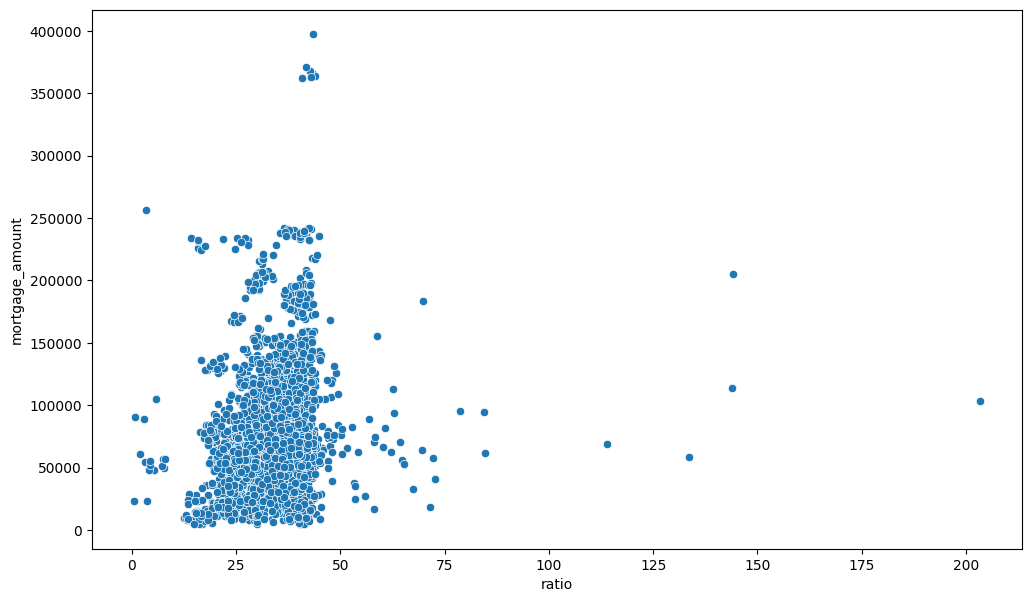

In [189]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='ratio',y='mortgage_amount',data=df)

In [190]:
def setRatio(df):
  ratio = df[0]
  if pd.isnull(ratio):
    return np.mean(ratio)
  else:
    return ratio

In [191]:
def setRecentCredit(df):
  recent_credit = df[0]
  if pd.isnull(recent_credit):
    return np.median(recent_credit)
  else:
    return recent_credit

In [192]:
def setCreditNumber(df):
  credit_number = df[0]
  if pd.isnull(credit_number):
    return np.median(credit_number)
  else:
    return credit_number

In [193]:
def Handle_missing(df):
    df['occupation'] = df[['occupation','loan_reason','loan_amount']].apply(setOccupation, axis = 1)

    df['loan_reason'] = df[['occupation','loan_reason','loan_amount']].apply(setLoanReason, axis = 1)

    df['mortgage_amount'] = df[['mortgage_amount','property_value']].apply(setMortgage, axis = 1)

    df['property_value'] = df[['mortgage_amount','property_value']].apply(setProperty, axis = 1)

    df['occupation_length'] = df[['occupation','occupation_length']].apply(setOccupationLength, axis = 1)

    df['late_payments'] = df[['derogatory_reports','late_payments']].apply(setPayments, axis = 1)

    df['derogatory_reports'] = df[['derogatory_reports','late_payments']].apply(derogatoryReports, axis = 1)

    df['oldest_credit_line'] = df[['oldest_credit_line','credit_number']].apply(setOldestCreditLine, axis = 1)

    df['ratio'] = df[['ratio','mortgage_amount']].apply(setRatio, axis = 1)

    df['recent_credit'] = df[['recent_credit','credit_number']].apply(setRecentCredit, axis = 1)

    df['credit_number'] = df[['credit_number','recent_credit']].apply(setCreditNumber, axis = 1)

    return df

df = Handle_missing(df)

/tmp/ipykernel_33/130458669.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  occupation = df[0]
/tmp/ipykernel_33/130458669.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loan_reason = df[1]
/tmp/ipykernel_33/130458669.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loan_amount = df[2]
/tmp/ipykernel_33/3402054058.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

In [194]:
print(df.isnull().sum())


id                       0
default                  0
loan_amount              0
mortgage_amount         22
property_value          22
loan_reason              0
occupation               0
occupation_length        0
derogatory_reports      37
late_payments            0
oldest_credit_line       0
recent_credit          436
credit_number          196
ratio                 1113
dtype: int64


In [195]:
import pandas as pd

# Assuming df is your DataFrame
# Calculate median for selected columns
median_values = df[['mortgage_amount', 'property_value', 'derogatory_reports',
                    'late_payments', 'oldest_credit_line', 'recent_credit',
                    'credit_number', 'ratio']].median()

# Replace NaNs with the median value in each column
df[['mortgage_amount', 'property_value', 'derogatory_reports',
    'late_payments', 'oldest_credit_line', 'recent_credit',
    'credit_number', 'ratio']] = df[['mortgage_amount', 'property_value', 'derogatory_reports',
                                     'late_payments', 'oldest_credit_line', 'recent_credit',
                                     'credit_number', 'ratio']].fillna(median_values)


In [196]:
print(df.isnull().sum())

id                    0
default               0
loan_amount           0
mortgage_amount       0
property_value        0
loan_reason           0
occupation            0
occupation_length     0
derogatory_reports    0
late_payments         0
oldest_credit_line    0
recent_credit         0
credit_number         0
ratio                 0
dtype: int64


In [197]:
print(df.head())

      id  default  loan_amount  mortgage_amount  property_value loan_reason  \
0  16537        0        20900          58299.0        78684.00     DebtCon   
1  14800        0        17400          56111.0       114521.00     HomeImp   
2  11317        0         8700          57254.0        86883.00     HomeImp   
3  13023        0         6000          69876.0        94394.07     HomeImp   
4  11652        0         9700          75566.0        92066.00     DebtCon   

  occupation  occupation_length  derogatory_reports  late_payments  \
0    ProfExe                3.0                 0.0            0.0   
1     Office                2.0                 8.0            2.0   
2      Other               16.0                 0.0            0.0   
3      Other                0.0                 0.0            1.0   
4     Office               14.0                 0.0            0.0   

   oldest_credit_line  recent_credit  credit_number      ratio  
0           98.662820            0.0   

In [198]:
df.head()

,id,default,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,16537,0,20900,58299.0,78684.00,DebtCon,ProfExe,3.0,0.0,0.0,98.662820,0.0,16.0,38.972004
1,14800,0,17400,56111.0,114521.00,HomeImp,Office,2.0,8.0,2.0,154.855524,1.0,24.0,38.695084
2,11317,0,8700,57254.0,86883.00,HomeImp,Other,16.0,0.0,0.0,172.166563,0.0,28.0,25.043437
3,13023,0,6000,69876.0,94394.07,HomeImp,Other,0.0,0.0,1.0,179.566667,0.0,32.0,34.889242
4,11652,0,9700,75566.0,92066.00,DebtCon,Office,14.0,0.0,0.0,94.987922,0.0,8.0,25.161183


In [199]:
le = LabelEncoder()
df['loan_reason'] = le.fit_transform(df['loan_reason'])

cols_to_scale = ['loan_amount', 'mortgage_amount', 'property_value', 'oldest_credit_line','ratio', 'occupation_length', 'derogatory_reports']
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [200]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df[['occupation']]).toarray()
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['occupation']))
df = pd.concat([df, one_hot_df], axis=1)
df = df.drop('occupation', axis=1)

df.head()

,id,default,loan_amount,mortgage_amount,property_value,loan_reason,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio,occupation_Mgr,occupation_Office,occupation_Other,occupation_ProfExe,occupation_Sales,occupation_Self
0,16537,0,0.194200,-0.290811,-0.404656,0,-0.800225,-0.426512,0.0,-0.977937,0.0,16.0,0.640508,0.0,0.0,0.0,1.0,0.0,0.0
1,14800,0,-0.115025,-0.339033,0.223520,1,-0.938482,3.049105,2.0,-0.296802,1.0,24.0,0.604520,0.0,1.0,0.0,0.0,0.0,0.0
2,11317,0,-0.883671,-0.313842,-0.260938,1,0.997117,-0.426512,0.0,-0.086967,0.0,28.0,-1.169625,0.0,0.0,1.0,0.0,0.0,0.0
3,13023,0,-1.122217,-0.035659,-0.129279,1,-1.214996,-0.426512,1.0,0.002732,0.0,32.0,0.109919,0.0,0.0,1.0,0.0,0.0,0.0
4,11652,0,-0.795321,0.089746,-0.170087,0,0.720603,-0.426512,0.0,-1.022482,0.0,8.0,-1.154322,0.0,1.0,0.0,0.0,0.0,0.0


In [201]:
df.to_csv('train_cleaned_data.csv', index=False)

In [202]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

In [203]:
print(df.head())

      id  default  loan_amount  mortgage_amount  property_value  loan_reason  \
0  16537        0     0.194200        -0.290811       -0.404656            0   
1  14800        0    -0.115025        -0.339033        0.223520            1   
2  11317        0    -0.883671        -0.313842       -0.260938            1   
3  13023        0    -1.122217        -0.035659       -0.129279            1   
4  11652        0    -0.795321         0.089746       -0.170087            0   

   occupation_length  derogatory_reports  late_payments  oldest_credit_line  \
0          -0.800225           -0.426512            0.0           -0.977937   
1          -0.938482            3.049105            2.0           -0.296802   
2           0.997117           -0.426512            0.0           -0.086967   
3          -1.214996           -0.426512            1.0            0.002732   
4           0.720603           -0.426512            0.0           -1.022482   

   recent_credit  credit_number     ratio  o

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [205]:
parameters = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'C': [1, 5, 10]}
svc_model = SVC(kernel = 'rbf', random_state = 42)
model = GridSearchCV(svc_model, parameters)
model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [1, 5, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]})

In [206]:
print("These are the best parameter you should choose in your model: ")
print(model.best_params_)
print(model.best_estimator_)

These are the best parameter you should choose in your model: 
{'C': 10, 'gamma': 0.1}
SVC(C=10, gamma=0.1, random_state=42)


In [207]:
# model = SVC(kernel='rbf', C=25, gamma=0.1, degree=2, random_state=42)
# model.fit(X_train, y_train)

In [208]:
# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluating the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9442307692307692
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       416
           1       0.97      0.74      0.84       104

    accuracy                           0.94       520
   macro avg       0.96      0.87      0.90       520
weighted avg       0.95      0.94      0.94       520



In [209]:
test = pd.read_csv('/kaggle/input/sas-viya-for-learners-challenge-2024-private/hmeq_test.csv')
test.head()

,id,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,12816,28100,32470.0,54522.0,DebtCon,Other,35.0,0.0,0.0,295.496684,0.0,23.0,38.799483
1,11678,10500,57880.0,66802.0,DebtCon,Other,2.0,0.0,0.0,94.598425,8.0,21.0,45.464766
2,13568,10900,NaN,76207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.392612
3,16525,50000,44000.0,59000.0,DebtCon,Office,12.0,0.0,1.0,102.500000,2.0,26.0,NaN
4,16160,7500,NaN,26850.0,HomeImp,Office,20.0,0.0,0.0,185.633333,1.0,16.0,NaN


In [210]:
test = Handle_missing(test)
test

/tmp/ipykernel_33/130458669.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  occupation = df[0]
/tmp/ipykernel_33/130458669.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loan_reason = df[1]
/tmp/ipykernel_33/130458669.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loan_amount = df[2]
/tmp/ipykernel_33/3402054058.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

,id,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,12816,28100,32470.0,54522.0,DebtCon,Other,35.0,0.0,0.0,295.496684,0.0,23.0,38.799483
1,11678,10500,57880.0,66802.0,DebtCon,Other,2.0,0.0,0.0,94.598425,8.0,21.0,45.464766
2,13568,10900,53344.9,76207.0,HomeImp,Mgr,7.0,7.0,6.0,179.341253,NaN,NaN,22.392612
3,16525,50000,44000.0,59000.0,DebtCon,Office,12.0,0.0,1.0,102.500000,2.0,26.0,NaN
4,16160,7500,18795.0,26850.0,HomeImp,Office,20.0,0.0,0.0,185.633333,1.0,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,16196,25000,82000.0,128325.0,DebtCon,Mgr,7.0,0.0,1.0,10.133333,NaN,41.0,NaN
758,16461,23400,89226.0,119604.0,DebtCon,Self,3.0,0.0,0.0,221.681383,1.0,26.0,34.556201
759,16619,15300,21383.0,38480.0,HomeImp,Mgr,20.0,0.0,1.0,182.600000,4.0,31.0,NaN
760,12593,8000,76600.0,96000.0,DebtCon,Mgr,2.0,0.0,0.0,73.033333,2.0,24.0,NaN


In [211]:
import pandas as pd

# Assuming df is your DataFrame
# Calculate median for selected columns
median_values = test[['mortgage_amount', 'property_value', 'derogatory_reports',
                    'late_payments', 'oldest_credit_line', 'recent_credit',
                    'credit_number', 'ratio']].median()

# Replace NaNs with the median value in each column
test[['mortgage_amount', 'property_value', 'derogatory_reports',
    'late_payments', 'oldest_credit_line', 'recent_credit',
    'credit_number', 'ratio']] = test[['mortgage_amount', 'property_value', 'derogatory_reports',
                                     'late_payments', 'oldest_credit_line', 'recent_credit',
                                     'credit_number', 'ratio']].fillna(median_values)

In [212]:
test['loan_reason'] = le.transform(test['loan_reason'])

test_onehot_df = encoder.transform(test[['occupation']]).toarray()
test_onehot_df = pd.DataFrame(test_onehot_df, columns=encoder.get_feature_names_out(['occupation']))
test = pd.concat([test, test_onehot_df], axis=1)
test = test.drop('occupation', axis=1)

# test_onehot_df = encoder2.transform(test[['loan_reason']]).toarray()
# test_onehot_df = pd.DataFrame(test_onehot_df, columns=encoder2.get_feature_names_out(['loan_reason']))
# test = pd.concat([test, test_onehot_df], axis=1)
# test = test.drop('loan_reason', axis=1)

cols_to_scale = ['loan_amount', 'mortgage_amount', 'property_value', 'oldest_credit_line','ratio', 'occupation_length', 'derogatory_reports']

test[cols_to_scale] = scaler.fit_transform(test[cols_to_scale])

In [213]:
test1 = test.drop(['id'], axis=1)
test1

,loan_amount,mortgage_amount,property_value,loan_reason,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio,occupation_Mgr,occupation_Office,occupation_Other,occupation_ProfExe,occupation_Sales,occupation_Self
0,0.975509,-0.799224,-0.759802,0,3.534413,-0.443169,0.0,1.250135,0.0,23.0,0.693912,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.718862,-0.276939,-0.562271,0,-0.923894,-0.443169,0.0,-0.972374,8.0,21.0,1.608496,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.680353,-0.370155,-0.410986,1,-0.248393,2.603045,6.0,-0.034876,1.0,20.0,-1.557374,1.0,0.0,0.0,0.0,0.0,0.0
3,3.083845,-0.562233,-0.687771,0,0.427108,-0.443169,1.0,-0.884960,2.0,26.0,0.100060,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.007675,-1.080304,-1.204923,1,1.507910,-0.443169,0.0,0.034732,1.0,16.0,0.100060,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,0.677069,0.218831,0.427364,0,-0.248393,-0.443169,1.0,-1.906799,1.0,41.0,0.100060,1.0,0.0,0.0,0.0,0.0,0.0
758,0.523035,0.367356,0.287081,0,-0.788794,-0.443169,0.0,0.433527,1.0,26.0,0.111666,0.0,0.0,0.0,0.0,0.0,1.0
759,-0.256761,-1.027109,-1.017848,1,1.507910,-0.443169,1.0,0.001175,4.0,31.0,0.100060,1.0,0.0,0.0,0.0,0.0,0.0
760,-0.959539,0.107838,-0.092604,0,-0.923894,-0.443169,0.0,-1.210945,2.0,24.0,0.100060,1.0,0.0,0.0,0.0,0.0,0.0


In [214]:
y_pred = model.predict(test1)

In [215]:
print(y_pred)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 0 1 0 0 0 0 

In [216]:
test_df = pd.DataFrame(y_pred)
test_df

,0
0,0
1,1
2,0
3,0
4,0
...,...
757,1
758,0
759,1
760,0


In [217]:
# Create the DataFrame
test_df_new = pd.DataFrame({
    'id': test.iloc[:, 0],
    'default': y_pred
})

# Display the DataFrame
print(test_df_new)

        id  default
0    12816        0
1    11678        1
2    13568        0
3    16525        0
4    16160        0
..     ...      ...
757  16196        1
758  16461        0
759  16619        1
760  12593        0
761  16388        0

[762 rows x 2 columns]


In [220]:
test_df_1 = test_df_new.to_csv('submission.csv', index=False)

In [219]:
df['default'].value_counts()

default
0    4156
1    1042
Name: count, dtype: int64